# Example of transfer learning from ImageNet, using a VGG16 network

In this lab we will continue what has been done during the convolutional networks lab from Tuesday and investigate the theory that transfer learning should help getting better results when the data we have at our disposal is limited.

We will be using a pre-trained VGG16 network.

VGG16 is a Convolutional Neural Network with five convolutional layers followed by three fully connected layers:

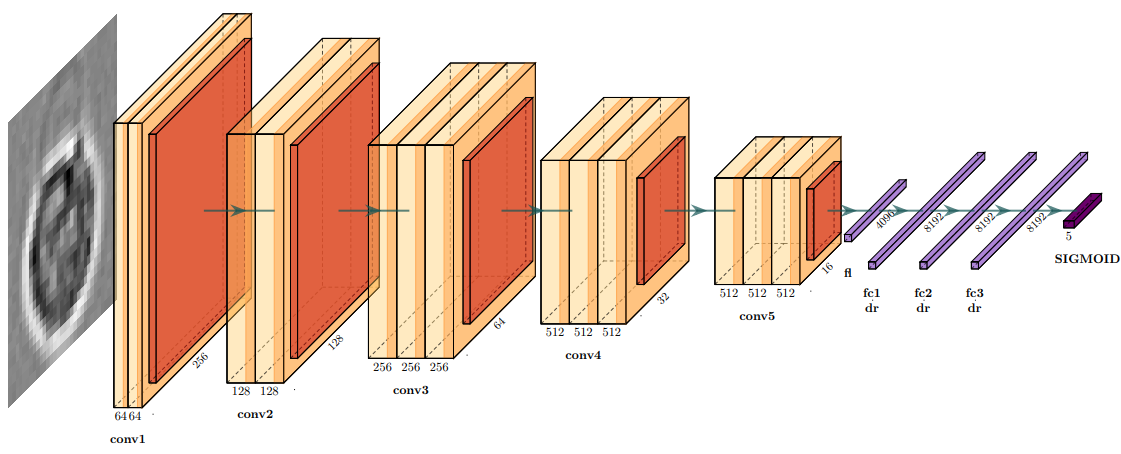

Since this architecture is fairly large, we will either have to be very patient when running on CPU or take advantage of GPU computing. One option is to use [Google Colab](https://colab.research.google.com/) which offers 12 hours of GPU time for free. 

Upload this notebook on colab to get started, then uncomment the following block of code to set up the environment:

In [ ]:
#Uncomment this code in google colab to checkout the course repository and unzip the data

#%cd /content
#!git clone https://github.com/NBISweden/workshop-neural-nets-and-deep-learning.git
#%cd /content/workshop-neural-nets-and-deep-learning/session_convolutionalNeuralNetworks/Labs/
#!unzip data.zip
#%cd /content/workshop-neural-nets-and-deep-learning/session_goodPracticesDatasetDesign/lab_transferLearning/

# Classification of Human Blood Cells (continued)

For this lab, we use the image set [Human White Blood Cells (BBBC045v1)](https://bbbc.broadinstitute.org/BBBC045) from the Broad Bioimage Benchmark Collection [Ljosa et al., Nature Methods, 2012].

Using fluorescence staining [[Label‐Free Identification of White Blood Cells Using Machine Learning (Nassar et. al)](https://www.ncbi.nlm.nih.gov/pmc/articles/PMC6767740/)], each blood cell has been classified into one of 5 categories: 
 - **B cells** (lymphocytes),
 - **T cells** (lymphocytes),
 - **eosinophils**,
 - **monocytes**,
 - **neutrophils**.

<img src="illustrations/WhiteBloodCells.png" width="500px" title="Blood cell illustration (Wikipedia)" align="center"/>
<center><i>(Illustration from <a href="https://en.wikipedia.org/wiki/White_blood_cell">Wikipédia</a>)</i></center>

## Brightfield dataset
For this lab, we only kept Brightfield images and cropped them into small grayscale patches of 32x32 pixels:

<img src="illustrations/bloodCells.png" title="Blood cells dataset" align="center"/>

These patches are in the **data/bloodcells_small/** folder, splitted into **testing** and **training** sets. In each set, images are splitted according to their categories:
```
└── data
    └── bloodcells_small
        ├── test
        │   ├── B
        │   ├── T
        │   ├── eosinophil
        │   ├── monocyte
        │   └── neutrophil
        └── train
            ├── B
            ├── T
            ├── eosinophil
            ├── monocyte
            └── neutrophil
```

Our goal is to use convolutional neural networks to automatically classify blood cells into one of the five categories, using only the 32x32 pixels brightfield images.

In [2]:
import numpy as np

from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dense, Flatten
from tensorflow.keras.layers import BatchNormalization, Dropout, Activation, Input

from tensorflow.keras.utils import to_categorical
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.optimizers import Adam

from tensorflow.keras.applications import VGG16

model = VGG16(
    include_top=False,
    weights="imagenet",
    input_shape=(32, 32, 3),
    pooling=None,
    classifier_activation="softmax",
)
import cnn_helper

# Loading the data in generators

We use Keras functions [`ImageDataGenerator`](https://keras.io/api/preprocessing/image/#imagedatagenerator-class) and [`flow_from_directory`](https://keras.io/api/preprocessing/image/#flowfromdirectory-method) to create generators for the training and testing datasets.

In [3]:
# create a data generator
datagen = ImageDataGenerator(
    rescale=1./255,
    featurewise_center=True, 
    featurewise_std_normalization=True
)
train_generator = datagen.flow_from_directory(
    # You can also try 'data/mnist/train/' which contains digits of size 28x28
    directory='data/bloodcells_small/train/', 
    # We use categorical classes, which means that classes will be one-hot encoded:
    class_mode='categorical',
    batch_size=8,
    target_size=(32, 32),
    shuffle=False,
    color_mode="grayscale")
test_generator = datagen.flow_from_directory(
    directory='data/bloodcells_small/test/',
    # We use categorical classes, which means that classes will be one-hot encoded:
    class_mode='categorical', 
    batch_size=8,
    target_size=(32, 32),
    shuffle=False,
    color_mode="grayscale")
num_classes = 5
input_shape = 32

Found 16742 images belonging to 5 classes.
Found 4051 images belonging to 5 classes.


In [ ]:
# Uncomment to try on the nmist dataset instead of the bloodcells
'''
# create a data generator
datagen = ImageDataGenerator()

train_generator = datagen.flow_from_directory(
    directory='data/mnist/train/', 
    class_mode='categorical', 
    batch_size=8,
    target_size=(28, 28),
    shuffle=False,
    seed=42,
    color_mode="grayscale")
test_generator = datagen.flow_from_directory(
    directory='data/mnist/test/',
    class_mode='categorical', 
    batch_size=8,
    target_size=(28, 28),
    shuffle=False,
    seed=42,
    color_mode="grayscale")
num_classes = 10
input_shape = 28

print ("Images per class in training:", cnn_helper.getClassSizes(train_generator))
print ("Images per class in testing:", cnn_helper.getClassSizes(test_generator))
'''

In [4]:
print ("Images per class in training:", cnn_helper.getClassSizes(train_generator))
print ("Images per class in testing:", cnn_helper.getClassSizes(test_generator))

Images per class in training: {0: 3430, 1: 3201, 2: 3265, 3: 3346, 4: 3500}
Images per class in testing: {0: 604, 1: 900, 2: 589, 3: 957, 4: 1001}


We can now check that the generators contain our data:

Category (one-hot encoded): [0. 1. 0. 0. 0.]
Image shape: (32, 32)


/home/claudio/anaconda3/envs/nn_dl_python/lib/python3.7/site-packages/keras_preprocessing/image/image_data_generator.py:716: UserWarning: This ImageDataGenerator specifies `featurewise_center`, but it hasn't been fit on any training data. Fit it first by calling `.fit(numpy_data)`.
  warnings.warn('This ImageDataGenerator specifies '
/home/claudio/anaconda3/envs/nn_dl_python/lib/python3.7/site-packages/keras_preprocessing/image/image_data_generator.py:724: UserWarning: This ImageDataGenerator specifies `featurewise_std_normalization`, but it hasn't been fit on any training data. Fit it first by calling `.fit(numpy_data)`.
  warnings.warn('This ImageDataGenerator specifies '


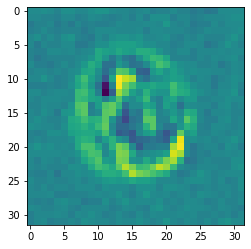

Category (one-hot encoded): [0. 0. 0. 0. 1.]
Image shape: (32, 32)


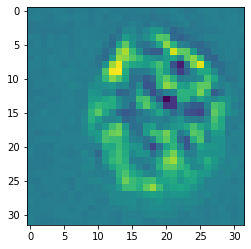

Category (one-hot encoded): [0. 0. 0. 1. 0.]
Image shape: (32, 32)


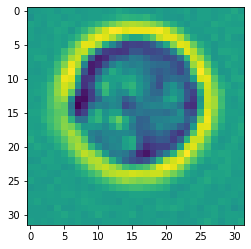

Category (one-hot encoded): [0. 0. 0. 1. 0.]
Image shape: (32, 32)


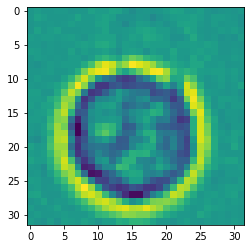

Category (one-hot encoded): [0. 0. 0. 1. 0.]
Image shape: (32, 32)


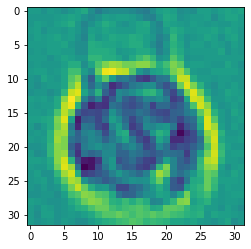

In [5]:
import random
import matplotlib.pyplot as plt

for i in range(5):
    batch_index = random.randrange(len(train_generator))
    images,categories= train_generator[batch_index]
    
    #Images are in the shape 32x32x1 and we need 32x32 to be display, so we squeeze the image:
    image = np.squeeze(images[0])
    
    print ("Category (one-hot encoded):", categories[0])
    print ("Image shape:", image.shape)
    plt.imshow(image)
    plt.show()

# Training the model
## A first CNN model

We can start by building a simple convolutional network with one convolutional layer followed by one max-pooling layer.

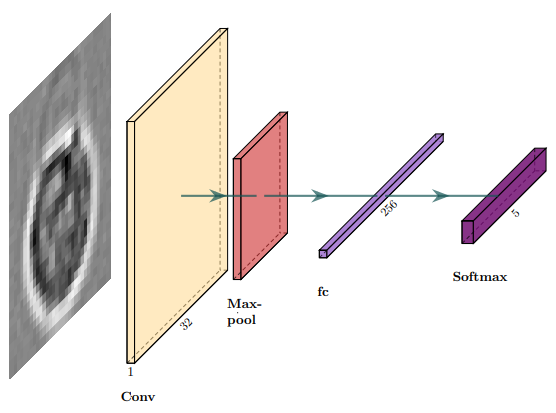

In [ ]:
num_filters = 1
filter_size = 2
pool_size = 2

# Build the model.
model = Sequential([
  Conv2D(num_filters, filter_size, input_shape=(input_shape,input_shape,1)),
  MaxPooling2D(pool_size=pool_size),
  Flatten(),
  Dense(num_classes, activation='softmax'),
])

# Compile the model.
model.compile(
  'adam',
  loss='categorical_crossentropy',
  metrics=['accuracy'],
)

In [ ]:
# Train the model.
model.fit(
  train_generator,
  epochs=3,
  validation_data=test_generator,
)

In [ ]:
# get random batch of images
batch_index = random.randrange(len(test_generator))
images, categories = test_generator[batch_index]

# compute predictions for the batch
predictions = model.predict(images)

# display predictions using argmax
print(np.argmax(predictions, axis=1))

# compare predictions with ground truth
print (np.argmax(categories, axis=1))

We can also plot confusion matrix of the whole generator, using the function:
```python
cnn_helper.plot_confusion_matrix_from_generator (model, generator)
```

In [ ]:
print ("Test set:")
cnn_helper.plot_confusion_matrix_from_generator (model, test_generator)

# Extensions

We can now modify our network to improve the accuracy of our classification. 

### Network depth
You can add more convolutional and max-pooling layers, and change the number of features in each convolutional layer.

For example, here are two iterations of convolutional layer plus max-pooling, with 16 and 32 features respectively, and a kernel size of 3:
```Python
model = Sequential([
    Conv2D(16, kernel_size=3, input_shape=(input_shape,input_shape,1)),
    MaxPooling2D(pool_size=2),
    Conv2D(32, kernel_size=3),
    MaxPooling2D(pool_size=2),
    [...]
])
```

### Dropout
Dropout layers can prevent overfitting. You can add dropout layers after max-pooling. A dropout of 20% is a good starting point.

```Python
model = Sequential([
    [...]
    Dropout(0.2),
    [...]
])
```

### Fully-connected Layers

Most CNNs use multiple fully-connected layers before the final softmax layer. You can add fully-connected layers using:

```Python
model = Sequential([
    [...]
    Dense(64, activation='relu'),
    [...]
])
```

### Convolution Parameters

Try to add an activation function to the convelutional layers (`activation='relu'`), and play with other parameters such as `strides` and `padding` (see details [here](https://keras.io/api/layers/convolution_layers/convolution2d/)).

```Python
model = Sequential([
    [...]
    Conv2D(
        num_filters,
        filter_size,
        input_shape=(32, 32, 1),
        strides=2,
        padding='same',
        activation='relu',
    ),
    [...]
])
```
 
### Example of more advanced convolutional neural network:
![image.png](attachment:image.png)

In [ ]:
num_filters = 16
# Create the model
model = Sequential([
    Conv2D(num_filters, kernel_size=(3, 3), activation='relu', input_shape=(input_shape,input_shape,1)),
    BatchNormalization(),
    MaxPooling2D(pool_size=(2, 2)),
    Dropout(0.2),
    Conv2D(num_filters*2, kernel_size=(3, 3), activation='relu'),
    MaxPooling2D(pool_size=(2, 2)),
    Dropout(0.2),
    Flatten(),
    Dense(num_filters*8, activation='relu'),
    Dense(num_classes, activation='softmax'),
])

# Compile the model.
model.compile(
  optimizer = Adam(learning_rate=0.0001),
  loss      = 'categorical_crossentropy',
  metrics   = ['accuracy'],
)

In [ ]:
# Train the model.
model.fit(
  train_generator,
  epochs=5,
  validation_data=test_generator,
  class_weight=cnn_helper.getClassWeights(train_generator)
)

In [ ]:
#print ("Train set:")
#cnn_helper.plot_confusion_matrix_from_generator (model, train_generator)

print ("Test set:")
cnn_helper.plot_confusion_matrix_from_generator (model, test_generator)

We need to load data in RGB color mode, as VGG16 expects input with 3 layers:

In [6]:
# create a data generator
train_generator_vgg = datagen.flow_from_directory(
    directory='data/bloodcells_small/train/', 
    class_mode='categorical', 
    batch_size=8,
    target_size=(32, 32),
    shuffle=False,
    color_mode="rgb")
test_generator_vgg = datagen.flow_from_directory(
    directory='data/bloodcells_small/test/',
    class_mode='categorical', 
    batch_size=8,
    target_size=(32, 32),
    shuffle=False,
    color_mode="rgb")

Found 16742 images belonging to 5 classes.
Found 4051 images belonging to 5 classes.


In order to perform transfer learning, we need the VGG16 model to be pre-trained on some other kind of data. Here, we choose a model trained on images that have very little to do with cell and microscopy: [ImageNet](http://image-net.org/)

> ImageNet is an image database organized according to the WordNet hierarchy (currently only the nouns), in which each node of the hierarchy is depicted by hundreds and thousands of images.

<img src="illustrations/imagenet.png">

## Question

If the images from ImageNet are completely irrelevant to our task, how do you think a model that has been pre-trained on it can be helpful?

In [30]:
from tensorflow.keras.applications import VGG16

model = VGG16(
    include_top=False,
    weights="imagenet",
    input_shape=(32, 32, 3),
    pooling=None,
    classifier_activation="softmax",
)

model.summary()


Model: "vgg16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_6 (InputLayer)         [(None, 32, 32, 3)]       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 32, 32, 64)        1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 32, 32, 64)        36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 16, 16, 64)        0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 16, 16, 128)       73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 16, 16, 128)       147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 8, 8, 128)         0     

Let's have a look at the model's filters using the code below (adapted from [here](https://machinelearningmastery.com/how-to-visualize-filters-and-feature-maps-in-convolutional-neural-networks/)) and see what kind of features this model might have extracted from ImageNet samples:

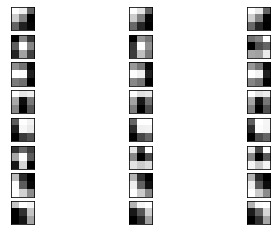

In [24]:
from matplotlib import pyplot

# retrieve weights from a hidden layer of your choice
filters, biases = model.layers[1].get_weights()

# normalize filter values to 0-1 so we can visualize them
f_min, f_max = filters.min(), filters.max()
filters = (filters - f_min) / (f_max - f_min)

# plot first few filters
n_filters, ix = 8, 1
for i in range(n_filters):
    # get the filter
    f = filters[:, :, :, i]
    # plot each channel separately
    for j in range(3):
        # specify subplot and turn of axis
        ax = pyplot.subplot(n_filters, 3, ix)
        ax.set_xticks([])
        ax.set_yticks([])
        # plot filter channel in grayscale
        pyplot.imshow(f[:, :, j], cmap='gray')
        ix += 1
pyplot.show()

Now we choose which layers we want to keep from the pre-trained model, then chop off the rest and add our "classification network" on top of it. This means taking the output from the last pre-trained layer, flattening it into a 1D tensor (2D if you count the "batches" dimension) and passing it to the last few dense layers.

But first, we need to "freeze" the pre-trained layers so that they remain untouched while training on the cell data, and only the classification layers are trained.

In [33]:
last_layer = 18

for layer in model.layers[:last_layer]:
    layer.trainable = False
    
last_pretrained_layer = model.layers[last_layer].output
# add new classifier layers
flat1 = Flatten()(last_pretrained_layer)
class1 = Dense(1024, activation='relu')(flat1)
output = Dense(5, activation='softmax')(class1)
# define new model
new_model = Model(inputs=model.inputs, outputs=output)
new_model.summary()

# Compile the model.
new_model.compile(
  optimizer = Adam(learning_rate=0.000001),
  loss      = 'categorical_crossentropy',
  metrics   = ['accuracy'],
)

#check again which layers are frozen, which are trainable
for layer in new_model.layers:
    print(layer.trainable)
    
new_model.fit(
  train_generator_vgg,
  epochs=30,
  validation_data=test_generator_vgg,
  class_weight=cnn_helper.getClassWeights(train_generator),
)

Model: "model_8"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_6 (InputLayer)         [(None, 32, 32, 3)]       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 32, 32, 64)        1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 32, 32, 64)        36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 16, 16, 64)        0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 16, 16, 128)       73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 16, 16, 128)       147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 8, 8, 128)         0   

/home/claudio/anaconda3/envs/nn_dl_python/lib/python3.7/site-packages/keras_preprocessing/image/image_data_generator.py:716: UserWarning: This ImageDataGenerator specifies `featurewise_center`, but it hasn't been fit on any training data. Fit it first by calling `.fit(numpy_data)`.
  warnings.warn('This ImageDataGenerator specifies '
/home/claudio/anaconda3/envs/nn_dl_python/lib/python3.7/site-packages/keras_preprocessing/image/image_data_generator.py:724: UserWarning: This ImageDataGenerator specifies `featurewise_std_normalization`, but it hasn't been fit on any training data. Fit it first by calling `.fit(numpy_data)`.
  warnings.warn('This ImageDataGenerator specifies '


     54/Unknown - 6s 104ms/step - loss: 1.5822 - accuracy: 0.0000e+00

KeyboardInterrupt: 

In [ ]:
print ("Train set:")
cnn_helper.plot_confusion_matrix_from_generator (model, train_generator_vgg)

print ("Test set:")
cnn_helper.plot_confusion_matrix_from_generator (model, test_generator_vgg)